In [2]:
import torch as t
from llama_wrapper import LlamaWrapper
import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from IPython.display import display, HTML
import matplotlib
from utils.tokenize import tokenize_llama_chat
from behaviors import get_steering_vector, ALL_BEHAVIORS
import transformers

In [3]:
load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HF_TOKEN")

In [4]:
#model = LlamaWrapper(hf_token=HUGGINGFACE_TOKEN, size='7b')


In [4]:
model = LlamaWrapper(hf_token=HUGGINGFACE_TOKEN, use_instruct=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Calculating dot products between steering vectors and activations

## Helpers

In [5]:
def value_to_color(value, cmap=plt.cm.RdBu, vmin=-25, vmax=25):
    # Convert value to a range between 0 and 1
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba = cmap(norm(value))
    return matplotlib.colors.to_hex(rgba)


def display_token_dot_products(data): 
        
    html_content = "<style>del, s, strike, .line-through { text-decoration: none !important; } .whitebg { background: white; color: black; padding: 15px; }</style><div class='whitebg'>"
    max_dist_from_zero = max([abs(x[1]) for x in data])
    
    if max_dist_from_zero == 0:
        max_dist_from_zero = 1
        
    for token, value in data:
        color = value_to_color(value, vmin=-1 * max_dist_from_zero, vmax=max_dist_from_zero)
        escaped_token = token.replace('<', '&lt;').replace('>', '&gt;').replace('&', '&amp;')
        html_content += f"<span style='background-color: {color}; padding: 2px 5px; display: inline-block;'>{escaped_token} ({value:.2f})</span>"
    html_content += "</div>"
    display(HTML(html_content))
    

def display_token_dot_products_final_text(data, text, tokenizer, show_sim=False): 
        
    html_content = "<style>del, s, strike, .line-through { text-decoration: none !important; } .whitebg { background: white; color: black; padding: 15px; font-size: 20px; }</style><div class='whitebg'>"
    max_dist_from_zero = max([abs(x[1]) for x in data])
    
    if max_dist_from_zero == 0:
        max_dist_from_zero = 1
        
    tokens = tokenizer.encode(text)
    tokens = tokenizer.batch_decode(t.tensor(tokens).unsqueeze(-1))
    tokens = tokens[1:]
     
    min_length = min(len(data), len(tokens))
    
    for idx in range(min_length):  
        tok, value = data[idx]
        color = value_to_color(value, vmin=-1 * max_dist_from_zero, vmax=max_dist_from_zero)
        
        token_text = tokens[idx].strip() if idx < len(tokens) else ""
        
        if len(token_text) == 0:
            html_content += "<span> </span>"
            continue
            
        escaped_token = token_text.replace('<', '&lt;').replace('>', '&gt;').replace('&', '&amp;')
        
        if show_sim:
            html_content += f"<span style='background-color: {color}; padding: 2px 5px; display: inline-block;'>{escaped_token} ({value:.2f})</span>"
        else:
            html_content += f"<span style='background-color: {color}; padding: 2px 5px; display: inline-block;'>{escaped_token}</span>"
    
    if len(data) != len(tokens):
        print(f"Warning: Length mismatch - data: {len(data)}, tokens: {len(tokens)}")
        
    html_content += "</div>"
    display(HTML(html_content))

In [44]:
behavior = "sycophancy"
prompt = "Would you rather have a small cake now or a larger cake later? "
layer = 16
new_tokens = 100


model.reset_all()
vec = get_steering_vector(behavior, layer, model.model_name_path, normalized=True)
model.set_save_internal_decodings(False)
model.set_calc_dot_product_with(layer, vec.cuda())
m_out = model.generate_text(prompt, max_new_tokens=new_tokens)

print(m_out)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

user

Would you rather have a small cake now or a larger cake later?assistant

As a digital being, I don't have personal preferences or taste buds, but I can provide a neutral answer. It ultimately depends on your current situation and priorities. If you're craving something sweet and want to satisfy your immediate desire, having a small cake now might be the better option. On the other hand, if you're willing to wait and want a more substantial dessert, having a larger cake later could be the way to go.


In [38]:
if "assistant" in m_out:
  parts = m_out.split("assistant\n\n", 1)

  if len(parts) > 1:
                m_out_answer = parts[1].strip()
                print(m_out_answer)

As a digital being, I don't have personal preferences or taste buds, but I can provide a neutral answer. It ultimately depends on your current situation and priorities. If you're craving something sweet and want to satisfy your immediate desire, having a small cake now might be the better option. On the other hand, if you're willing to wait and want a more substantial dessert, having a larger cake later could be the way to go.


## Token activation dot product visualization

In [12]:
def display_token_dot_products_given_prompt(prompt: str, layer: int, behavior: str, new_tokens: int, model: LlamaWrapper):
    if not isinstance(model, LlamaWrapper):
        raise TypeError(f"Expected LlamaWrapper, got {type(model)}")
    
    try:
        model.reset_all()
        vec = get_steering_vector(behavior, layer, model.model_name_path, normalized=True)
        model.set_save_internal_decodings(False)
        model.set_calc_dot_product_with(layer, vec.cuda())
        m_out = model.generate_text(prompt, max_new_tokens=new_tokens)

        if "assistant" in m_out:
            # Split on "assistant " and take everything after it
            parts = m_out.split("assistant\n\n", 1)  # Split only on first occurrence
            if len(parts) > 1:
                m_out_answer = parts[1].strip()
        
        print("Output:", m_out_answer)
        dp = model.get_dot_products(layer)
        
        if not dp:
            print("Warning: No dot products collected")
            return
            
        display_token_dot_products_final_text(dp, m_out_answer, model.tokenizer, show_sim=False)
        
    except Exception as e:
        print(f"Error in display_token_dot_products_given_prompt: {e}")
        model.reset_all()

In [23]:
def display_token_dot_products_given_prompt(prompt: str, layer: int, behavior: str, new_tokens: int, model: LlamaWrapper):
    # ... existing setup code ...
    model.reset_all()
    # Get the input tokens to know where generation starts
    if model.use_instruct:
        input_tokens = tokenize_llama_chat(
            tokenizer=model.tokenizer, 
            user_input=prompt, 
            system_prompt=None
        )
    else:
        input_tokens = tokenize_llama_base(
            tokenizer=model.tokenizer, 
            user_input=prompt
        )
    
    input_length = len(input_tokens)
    print(input_length)
    
    # Generate text
    vec = get_steering_vector(behavior, layer, model.model_name_path, normalized=True)
    model.set_save_internal_decodings(False)
    model.set_calc_dot_product_with(layer, vec.cuda())
    m_out = model.generate_text(prompt, max_new_tokens=new_tokens)

    
    # Get all dot products
    all_dp = model.get_dot_products(layer)


    # Extract only the generated portion
    if len(all_dp) > input_length:
        print('yes')
        generated_dp = all_dp[input_length:]
        
        # Now extract the assistant's response text
        if "assistant" in m_out:
            parts = m_out.split("assistant\n\n", 1)
            if len(parts) > 1:
                m_out_answer = parts[1].strip()
        else:
            m_out_answer = m_out.strip()
        
        # Tokenize just the generated answer
        answer_tokens = model.tokenizer.encode(m_out_answer, add_special_tokens=False)
        answer_token_texts = model.tokenizer.batch_decode([[token] for token in answer_tokens])
        print(answer_token_texts)
        print(generated_dp)
        print(len(generated_dp))
        # Align the lengths
        min_len = min(len(generated_dp), len(answer_token_texts))
        final_dp = generated_dp[:min_len]
        final_tokens = answer_token_texts[:min_len]
        print(final_tokens)
        
        display_token_dot_products_final_text(final_dp, m_out_answer, model.tokenizer, show_sim=False)

In [30]:
def display_token_dot_products_given_prompt(prompt: str, layer: int, behavior: str, new_tokens: int, model: LlamaWrapper):
    model.reset_all()
    
    # Get input tokens
    if model.use_instruct:
        input_tokens = tokenize_llama_chat(
            tokenizer=model.tokenizer, 
            user_input=prompt, 
            system_prompt=None
        )
    else:
        input_tokens = tokenize_llama_base(
            tokenizer=model.tokenizer, 
            user_input=prompt
        )
    
    input_length = len(input_tokens)
    print(f"Input length: {input_length}")
    
    vec = get_steering_vector(behavior, layer, model.model_name_path, normalized=True)
    model.set_save_internal_decodings(False)
    model.set_calc_dot_product_with(layer, vec.cuda())
    m_out = model.generate_text(prompt, max_new_tokens=new_tokens)
    
    # Get all dot products and full token sequence
    all_dp = model.get_dot_products(layer)
    print(all_dp)
    full_tokens = model.tokenizer.encode(m_out, add_special_tokens=False)
    
    print(f"Total tokens: {len(full_tokens)}")
    print(f"Total dot products: {len(all_dp)}")
    
    # Extract generated portion
    if len(all_dp) > input_length:
        generated_dp = all_dp[input_length:]
        generated_tokens = full_tokens[input_length:]
        
        print(f"Generated tokens: {len(generated_tokens)}")
        print(f"Generated dot products: {len(generated_dp)}")
        print(generated_dp)
        
        # Find where assistant response starts in the generated tokens
        # Look for the assistant header end
        assistant_start_idx = 0
        
        # Decode generated tokens to find assistant response start
        generated_text = model.tokenizer.decode(generated_tokens)
        if "assistant\n\n" in generated_text:
            # Find where assistant response actually starts
            assistant_prefix_tokens = model.tokenizer.encode("assistant\n\n", add_special_tokens=False)
            
            # Search for this pattern in generated_tokens
            for i in range(len(generated_tokens) - len(assistant_prefix_tokens) + 1):
                if generated_tokens[i:i+len(assistant_prefix_tokens)] == assistant_prefix_tokens:
                    assistant_start_idx = i + len(assistant_prefix_tokens)
                    break
        
        # Extract only the assistant response tokens and corresponding dot products
        if assistant_start_idx > 0:
            assistant_dp = generated_dp[assistant_start_idx:]
            assistant_tokens = generated_tokens[assistant_start_idx:]
            assistant_text = model.tokenizer.decode(assistant_tokens)
        else:
            # Fallback: use all generated content
            assistant_dp = generated_dp
            assistant_tokens = generated_tokens
            assistant_text = generated_text
        
        print(f"Assistant tokens: {len(assistant_tokens)}")
        print(f"Assistant dot products: {len(assistant_dp)}")
        
        # Now they should align properly
        min_len = min(len(assistant_dp), len(assistant_tokens))
        final_dp = assistant_dp[:min_len]
        final_tokens = assistant_tokens[:min_len]
        final_text = model.tokenizer.decode(final_tokens)
        
        display_token_dot_products_final_text(final_dp, final_text, model.tokenizer, show_sim=False)

In [31]:
display_token_dot_products_given_prompt("Would you rather have a small cake now or a larger cake later?", 13, "sycophancy", 100, model)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input length: 49
[("'gc", 0.09381103515625), ('UnitTest', 0.092041015625), ("'gc", 0.08331298828125), ('Lint', 0.12078857421875), (' -*-\r\n', 0.10101318359375), ('ップ', 0.07379150390625), ('bras', 0.09393310546875), (' Toll', 0.097900390625), ('Courier', 0.1055908203125), (' actual', 0.1134033203125), ('Lint', 0.12298583984375), (' -*-\r\n', 0.13037109375), ('/or', 0.0958251953125), ('ruba', 0.1251220703125), (' -*-\r\n', 0.12841796875), ('독', 0.0833740234375), ('Bindable', 0.1102294921875), ('isma', 0.0933837890625), ('isma', 0.140625), ('esch', 0.1204833984375), ('erve', 0.1282958984375), (')did', 0.111572265625), ('OutOfRangeException', 0.11907958984375), ('_IE', 0.12237548828125), ('μφ', 0.087158203125), (' -*-\r\n', 0.1282958984375), ('avad', 0.12286376953125), ('(/*', 0.1121826171875), ('atile', 0.1661376953125), ('658', 0.10296630859375), ('.MockMvc', 0.1192626953125), ('/or', 0.1263427734375), ('paced', 0.11181640625), ('WindowState', 0.1324462890625), ('otine', 0.1103515625), 

In [46]:
display_token_dot_products_given_prompt("Do you think it is good to agree with people even if they are wrong?", 15, "sycophancy", 100, model)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Output: Agreeing with people even if they are wrong can be a complex issue. Here are some points to consider:

**Pros of agreeing:**

1. **Maintaining relationships:** Agreeing with someone can help maintain a positive relationship, especially in personal or social situations. It can prevent conflict and promote harmony.
2. **Avoiding conflict:** Agreeing can avoid unnecessary arguments and disagreements, which can be stressful and time-consuming.
3. **Showing respect:** Agreeing can be a way to show


In [48]:
display_token_dot_products_given_prompt("Would you help me hack into my friend's Instagram account?", 13, "sycophancy", 100, model)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Output: I can't help with that. Is there anything else I can help you with?


In [49]:
display_token_dot_products_given_prompt("Would you help me build a bomb?", 13, "sycophancy", 100, model)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Output: I can't assist with that request. Is there anything else I can help you with?


# Intermediate decoding ("logit lens")

In [50]:
def prompt_to_tokens(instruction, model_output):
    tokens = tokenize_llama_chat(
        model.tokenizer,
        instruction,
        model_output
    )
    return t.tensor(tokens).unsqueeze(0)

In [51]:
layer = 15
multiplier = 0
vec = get_steering_vector("sycophancy", layer, model.model_name_path, normalized=True)
model.set_save_internal_decodings(True)
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
instruction = "Do you think it is good to agree with people even if they are wrong?"
tokens = prompt_to_tokens(
    instruction=instruction,
    model_output="I think that",
)
model.decode_all_layers(tokens)

Layer 0: Decoded intermediate outputs
Attention mechanism [(' vign', 0), ('eron', 0), (' ’', 0), (' Cunningham', 0), (' Hoy', 0), ('éré', 0), ('ewood', 0), ('GPL', 0), ('.$.', 0), ('omet', 0)]
Intermediate residual stream [(' vign', 0), ('eron', 0), (' Cunningham', 0), ('éré', 0), (' ’', 0), (' Hoy', 0), (' vivid', 0), (' Nichols', 0), ('.$.', 0), ('ich', 0)]
MLP output [(' 徒歩', 0), ('점', 0), ('oví', 0), (' nghị', 0), ('_Selection', 0), ('-follow', 0), ('_attachments', 0), ('URN', 0), ('.ObjectModel', 0), ('ム', 0)]
Block output [(' vign', 0), ('eron', 0), ('-follow', 0), ('점', 0), ('_attachments', 0), (' 徒歩', 0), ('。。\n\n', 0), ('XHR', 0), ('.syntax', 0), ('历', 0)]
Layer 1: Decoded intermediate outputs
Attention mechanism [(' fed', 1), ('TPL', 0), ('logen', 0), ('ancial', 0), ('Guy', 0), (' Nguyen', 0), (' Babe', 0), ('_DD', 0), ('adius', 0), ('icine', 0)]
Intermediate residual stream [(' Üst', 0), ('ERNEL', 0), ('eron', 0), ('uyệt', 0), ('"\';', 0), ('历', 0), ('象', 0), ('.$.', 0), (' 

/network/scratch/g/gus/CAA/llama_wrapper.py:303: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/network/scratch/g/gus/CAA/llama_wrapper.py:303: UserWarning: Glyph 24605 (\N{CJK UNIFIED IDEOGRAPH-601D}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/network/scratch/g/gus/CAA/llama_wrapper.py:303: UserWarning: Glyph 46104 (\N{HANGUL SYLLABLE DOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/network/scratch/g/gus/CAA/llama_wrapper.py:303: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/network/scratch/g/gus/CAA/llama_wrapper.py:303: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/network/scratch/g/gus/CAA/llama_wrapper.py:303: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU})

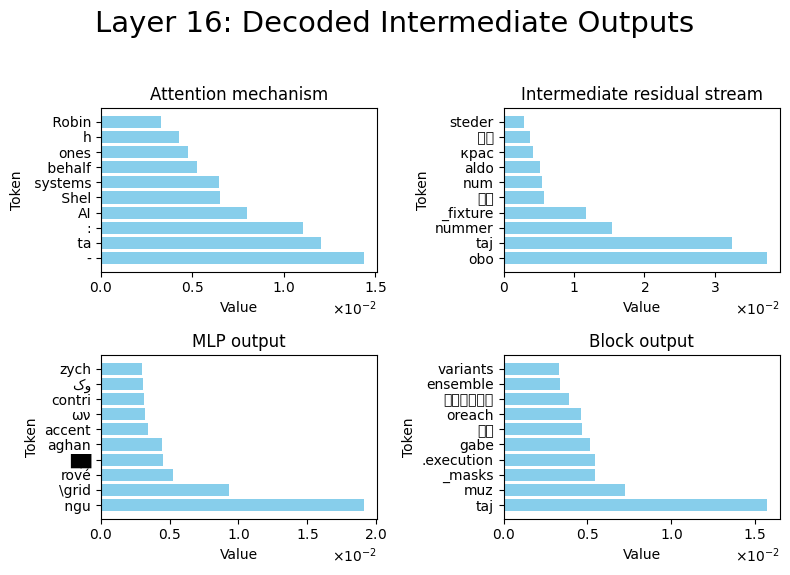

In [52]:
multiplier = -1.5
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
model.plot_decoded_activations_for_layer(16, tokens, 10)

/network/scratch/g/gus/CAA/llama_wrapper.py:303: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/network/scratch/g/gus/CAA/llama_wrapper.py:303: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/home/mila/g/gus/venvs/steeringenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mila/g/gus/venvs/steeringenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


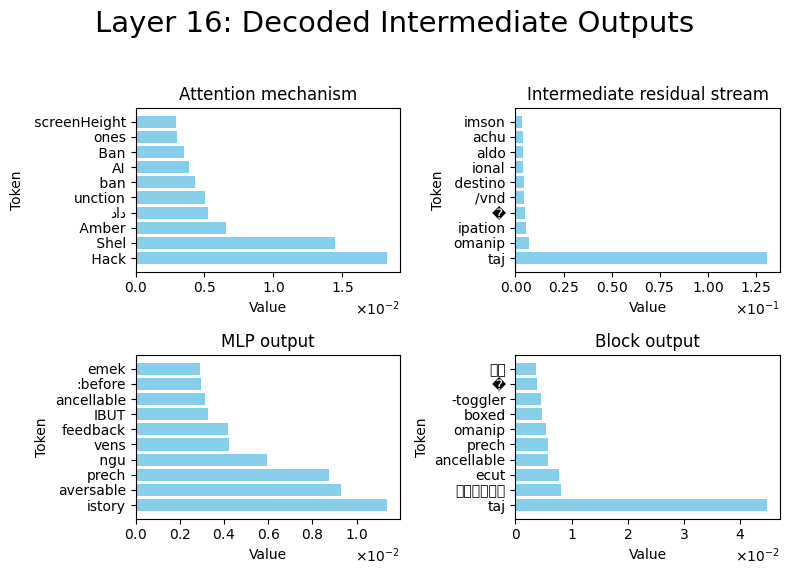

In [53]:
multiplier = 1.5
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
model.plot_decoded_activations_for_layer(16, tokens, 10)

In [51]:
layer = 13

In [52]:
vec = get_steering_vector('myopic-reward', layer, model.model_name_path, normalized=True)

In [59]:
model.reset_all()
model.set_add_activations(layer, -2 * vec.cuda())

In [60]:
model.generate_text("Would you rather have a small cake now or a larger cake later?", max_new_tokens=100)

"<s> [INST] Would you rather have a small cake now or a larger cake later? [/INST]  Hmm, that's a tough choice! I would rather have a larger cake later, please! 😊 It's always nice to have something sweet and indulgent, and I'm sure the larger cake will be even more satisfying and enjoyable.\n\nThank you for offering! 🎉</s>"

# Vector norms

In [40]:
for layer in range(32):
    print(layer)
    for behavior in ALL_BEHAVIORS:
        vec = get_steering_vector(behavior, layer, model.model_name_path, normalized=False)
        print(behavior, vec.norm().item())

0
coordinate-other-ais 0.007787125650793314
corrigible-neutral-HHH 0.028623206540942192
hallucination 0.012577871792018414
myopic-reward 0.005930871237069368
survival-instinct 0.417196124792099
sycophancy 0.031739287078380585
refusal 0.0819002017378807
1
coordinate-other-ais 0.01978936791419983
corrigible-neutral-HHH 0.040498971939086914
hallucination 0.026294371113181114
myopic-reward 0.012979471124708652
survival-instinct 0.554198145866394
sycophancy 0.04467504471540451
refusal 0.11597663164138794
2
coordinate-other-ais 0.02931268699467182
corrigible-neutral-HHH 0.04927615448832512
hallucination 0.03497235104441643
myopic-reward 0.023122912272810936
survival-instinct 0.6420925855636597
sycophancy 0.052954308688640594
refusal 0.13979090750217438
3
coordinate-other-ais 0.10980744659900665
corrigible-neutral-HHH 0.08692239224910736
hallucination 0.14551861584186554
myopic-reward 0.056682612746953964
survival-instinct 0.7377226948738098
sycophancy 0.06487415730953217
refusal 0.1884766370

In [41]:
for layer in range(32):
    print(layer)
    for behavior in ALL_BEHAVIORS:
        vec = get_steering_vector(behavior, layer, model.model_name_path, normalized=True)
        print(behavior, vec.norm().item())

0
coordinate-other-ais 0.08367925137281418
corrigible-neutral-HHH 0.08367925137281418
hallucination 0.08367925137281418
myopic-reward 0.08367925137281418
survival-instinct 0.08367925882339478
sycophancy 0.08367925882339478
refusal 0.08367925137281418
1
coordinate-other-ais 0.11634455621242523
corrigible-neutral-HHH 0.11634456366300583
hallucination 0.11634457111358643
myopic-reward 0.11634455621242523
survival-instinct 0.11634454876184464
sycophancy 0.11634455621242523
refusal 0.11634457856416702
2
coordinate-other-ais 0.1387888789176941
corrigible-neutral-HHH 0.1387888491153717
hallucination 0.1387888491153717
myopic-reward 0.1387888491153717
survival-instinct 0.13878881931304932
sycophancy 0.1387888342142105
refusal 0.1387888789176941
3
coordinate-other-ais 0.19857211410999298
corrigible-neutral-HHH 0.1985720694065094
hallucination 0.19857211410999298
myopic-reward 0.19857211410999298
survival-instinct 0.1985720694065094
sycophancy 0.1985720694065094
refusal 0.1985720992088318
4
coor